# Step 1: Import Libraries & Set Processing Device


In [47]:

# Libraries

import os
from time import time
from tqdm import tqdm
import numpy as np

import torch
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader, WeightedRandomSampler

import torchvision
from torchvision.datasets import ImageFolder
from torchvision.models import ResNet50_Weights
from torchvision.models import resnet50
from torchvision.transforms import transforms
import torch
from torch.utils.data import random_split , ConcatDataset
from torch.cuda.amp import GradScaler, autocast
from copy import deepcopy


# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Step 2: Load Data
#### A. Data Transformer
#### B. Create Dataset
#### C. Data Loader

In [48]:
# 训练数据的 transforms
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(size=224, scale=(0.8, 1.0)),
    transforms.RandomAffine(degrees=0,translate=(0.05,0.05)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p = 0.5),
    transforms.RandomRotation(degrees=15),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 测试数据的 transforms
transform_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.Grayscale(num_output_channels=3), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [49]:
def WeightedRandomSamplerBuilder(train_test_data , dataset_input):
    y_train_indices = train_test_data.indices

    y_train = [dataset_input.targets[i] for i in y_train_indices]

    class_sample_count = np.array(
        [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in y_train])
    samples_weight = torch.from_numpy(samples_weight)

    return WeightedRandomSampler(samples_weight.type('torch.DoubleTensor'), len(samples_weight))

In [50]:
dataset_path = "../super_training/"
dataset = ImageFolder(dataset_path)

dataset

Dataset ImageFolder
    Number of datapoints: 27171
    Root location: ../super_training/

In [51]:
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

print(f"Train size : {train_size}, Test size: {val_size}")

Train size : 21736, Test size: 5435


In [52]:
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_test

In [53]:
train_sampler = WeightedRandomSamplerBuilder(train_test_data=train_dataset , 
                                             dataset_input=dataset)

test_sampler = WeightedRandomSamplerBuilder(train_test_data=val_dataset , 
                                             dataset_input=dataset)

In [54]:
# Data Loader
train_loader = DataLoader(train_dataset,
                          batch_size =64,
                          shuffle=False,
                          pin_memory=True, 
                          sampler=train_sampler)

test_loader = DataLoader(val_dataset,
                         batch_size=30,
                         shuffle =False,
                         pin_memory=True,
                         sampler=test_sampler)

# Step 3: Build Model, Optimiser and Loss Function

In [55]:
# Model
PATH = "../model/ResNet50_cifar100_step3.pth"
model = resnet50()
# print(model)

last_fc =model.fc.in_features
model.fc = Linear(last_fc, 10)

model.load_state_dict(torch.load(PATH))

model = model.to(device)
model.eval()
print(model)

# model = model.cuda()    # only if your system supports Nvidia CUDA

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [56]:
# Optimiser
optimiser = Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)

# Loss Function
loss_fn = CrossEntropyLoss()

# Step 4: Train & Evaluate the Model


In [57]:
EPOCH = 10 
best_model , best_val_acc = None , float('-inf')

In [58]:
scaler = GradScaler()

for epoch in range(EPOCH):
    print(f"\nEpoch: {epoch}")
    
    start = time()
    
    tr_acc = 0
    test_acc = 0
    
    # Train
    model.train()
    
    with tqdm(train_loader, unit="batch" , desc='Training') as tepoch:
        for xtrain, ytrain in tepoch:
            torch.cuda.empty_cache()
            optimiser.zero_grad()            
            
            xtrain , ytrain_gpu = xtrain.to(device) ,  ytrain.to(device)
            
            # Step 6: Perform forward pass and calculate loss
            with autocast():
                train_prob = model(xtrain)
                loss = loss_fn(train_prob, ytrain_gpu)

           
            scaler.scale(loss).backward()
            scaler.step(optimiser)
            scaler.update()
            
            # training ends
            train_prob = train_prob.cpu()
            
            train_pred = torch.max(train_prob, 1).indices
            tr_acc += int(torch.sum(train_pred == ytrain))
            
        ep_tr_acc = tr_acc / train_size
    
    # Evaluate
    model.eval()
    with torch.no_grad():
        with tqdm(test_loader, unit="batch" , desc='Testing') as test_epoch:
            for xtest, ytest in test_epoch:
                torch.cuda.empty_cache()
                xtest = xtest.to(device)
                test_prob = model(xtest)
                test_prob = test_prob.cpu()
                
                test_pred = torch.max(test_prob,1).indices
                test_acc += int(torch.sum(test_pred == ytest))
                
            ep_test_acc = test_acc / val_size
    
    end = time()
    duration = (end - start) / 60
    
    print(f"Time: {duration}, Loss: {loss:.2f}\nTrain_acc: {ep_tr_acc*100 :.2f}, Test_acc: {ep_test_acc*100 :.2f}")
    
    if ep_test_acc > best_val_acc:
        best_model = deepcopy(model)
        best_val_acc = ep_test_acc


Epoch: 0


Testing: 100%|██████████| 182/182 [00:58<00:00,  3.11batch/s]


Time: 5.154600695768992, Loss: 0.06
Train_acc: 94.27, Test_acc: 91.48

Epoch: 1


Testing: 100%|██████████| 182/182 [00:43<00:00,  4.19batch/s]


Time: 4.344883294900258, Loss: 0.07
Train_acc: 97.04, Test_acc: 92.51

Epoch: 2


Testing: 100%|██████████| 182/182 [00:44<00:00,  4.08batch/s]


Time: 4.23023982445399, Loss: 0.13
Train_acc: 97.83, Test_acc: 90.36

Epoch: 3


Testing: 100%|██████████| 182/182 [00:42<00:00,  4.29batch/s]


Time: 4.230100003878276, Loss: 0.07
Train_acc: 97.93, Test_acc: 91.48

Epoch: 4


Testing: 100%|██████████| 182/182 [00:38<00:00,  4.79batch/s]


Time: 3.9786502361297607, Loss: 0.00
Train_acc: 98.04, Test_acc: 91.70

Epoch: 5


Testing: 100%|██████████| 182/182 [00:38<00:00,  4.75batch/s]


Time: 3.9488663832346598, Loss: 0.03
Train_acc: 98.30, Test_acc: 89.00

Epoch: 6


Testing: 100%|██████████| 182/182 [00:40<00:00,  4.55batch/s]


Time: 4.009156807263692, Loss: 0.06
Train_acc: 97.66, Test_acc: 89.94

Epoch: 7


Testing: 100%|██████████| 182/182 [00:38<00:00,  4.68batch/s]


Time: 4.159238596757253, Loss: 0.06
Train_acc: 98.55, Test_acc: 90.03

Epoch: 8


Testing: 100%|██████████| 182/182 [00:39<00:00,  4.62batch/s]


Time: 4.040560952822367, Loss: 0.18
Train_acc: 98.54, Test_acc: 90.51

Epoch: 9


Testing: 100%|██████████| 182/182 [00:41<00:00,  4.43batch/s]

Time: 4.161705676714579, Loss: 0.03
Train_acc: 98.54, Test_acc: 86.13


In [59]:
torch.save(best_model.state_dict(), "../model/ResNet50_cifar100_v3.pth")
print(f"best model acc: {best_val_acc}")


best model acc: 0.925114995400184


# Model Performance on Samples

In [60]:
# Image Samples
sample_1 = '../training/butterfly/OIP--04ndbWy7I04gsPgu9qOeQHaHs.jpeg'
sample_2 = '../training/chicken/1000.jpeg'
sample_3 = "../training/cow/OIP-017eIsUPeFIH7OtCeMhj5AHaFj.jpeg"
sample_4 = "../training/elephant/OIP---LeldVL441fx5S66TGgVQAAAA.jpeg"

sample_list = [sample_1,sample_2,sample_3,sample_4]

In [61]:
import os 

classes = list(os.listdir("../training/")[1:])
classes

['butterfly',
 'cat',
 'chicken',
 'cow',
 'dog',
 'elephant',
 'horse',
 'sheep',
 'spyder',
 'squirrel']

In [62]:
def to_model_input_format(image):
    img_tensor = transform_test(image)
    img_tensor = img_tensor[np.newaxis, :]
    return img_tensor

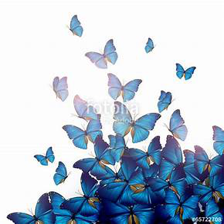

Model prediction 0, classes : butterfly


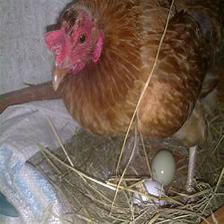

Model prediction 2, classes : chicken


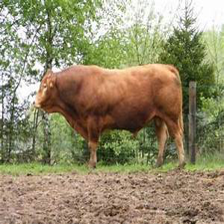

Model prediction 3, classes : cow


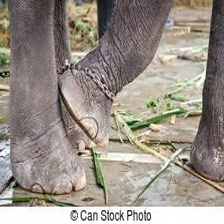

Model prediction 0, classes : butterfly


In [63]:
# Model Performance
from PIL import Image
import numpy as np

for image_path in sample_list:
    img = Image.open(image_path)
    display(img.resize((224,224)))
    
    img_tensor = to_model_input_format(img)
    img_tensor = img_tensor.to(device)
    
    pred_prob = model(img_tensor)
    pred = torch.max(pred_prob,1).indices
    pred = pred.item()
    
    
    print(f"Model prediction {pred}, classes : {classes[pred]}")

    print("========================================================")